
## Chap 08. DQN

---- 

- conda env : [ai_robotics](../README.md#setup-a-conda-environment)

---


- DQN
    - Experience Replay
    - Target Network

In [2]:
# @title Chap 8.1 OpenAI Gym
import gymnasium as gym
import renderlab as rl
import numpy as np

env = gym.make("CartPole-v1", render_mode = "rgb_array")
# env = gym.make("CartPole-v1", render_mode = "human")
env = rl.RenderFrame(env, "./temp_output")

state = env.reset()[0]
done = False

state = env.reset()[0]
print("env.reset(): ", env.reset())
print("state: ", state)
action_space = env.action_space
print("action_space: ", action_space)
print("")

done = False
while not done:
    env.render()
    action = np.random.choice([0, 1])
    next_state, reward, terminated, truncated, info = env.step(action)
    # print('action:', action)
    # print('state:', state)
    # print('next_state:', next_state)
    # print('reward:', reward)
    # print('terminated:', terminated)
    # print('truncated:', truncated)
    # print('info:', info)
    state = next_state
    if terminated or truncated:
        break

env.play()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


env.reset():  (array([-0.03229922,  0.0436798 ,  0.01346617, -0.00577445], dtype=float32), {})
state:  [-0.00552168 -0.02747698  0.04215047 -0.00999476]
action_space:  Discrete(2)

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [ ]:
# @title Chap 8.2.1 Experience Replay
from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        # action = np.array([x[1] for x in data])
        # reward = np.array([x[2] for x in data])
        action = np.stack([x[1] for x in data])
        reward = np.stack([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.stack([x[4] for x in data])
        return state, action, reward, next_state, done

env = gym.make('CartPole-v0', render_mode='rgb_array')
env = rl.RenderFrame(env, "./temp_output")
replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=32)

for episode in range(10):
    state = env.reset()[0]
    done = False
    while not done:
        action = 0
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated | truncated
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

state, action, reward, next_state, done = replay_buffer.get_batch()
# print(state.shape)       # (32, 4)
# print(action.shape)      # (32,)
# print(reward.shape)      # (32,)
# print(next_state.shape)  # (32, 4)
# print(done.shape)        # (32,)
# env.play()

In [5]:
print(state.shape)       # (32, 4)
print(action.shape)      # (32,)
print(reward.shape)      # (32,)
print(next_state.shape)  # (32, 4)
print(done.shape)        # (32,)
env.play()

(32, 4)
(32,)
(32,)
(32, 4)
(32,)
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


### Chap 8.2.3 Target Network

In [6]:
# @title Chap 8.2.3 Target Network - 1
# Test code for deque
from collections import deque

dq = deque(maxlen = 3)
for i in range(10):
    dq.append(i)
    print(dq)

deque([0], maxlen=3)
deque([0, 1], maxlen=3)
deque([0, 1, 2], maxlen=3)
deque([1, 2, 3], maxlen=3)
deque([2, 3, 4], maxlen=3)
deque([3, 4, 5], maxlen=3)
deque([4, 5, 6], maxlen=3)
deque([5, 6, 7], maxlen=3)
deque([6, 7, 8], maxlen=3)
deque([7, 8, 9], maxlen=3)


In [7]:
# @title Chap 8.2.3 Target Network - 2
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
import random
import numpy as np

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = torch.tensor(np.stack([x[0] for x in data]))
        action = torch.tensor(np.array([x[1] for x in data]).astype(np.long))
        reward = torch.tensor(np.array([x[2] for x in data]).astype(np.float32))
        next_state = torch.tensor(np.stack([x[3] for x in data]))
        done = torch.tensor(np.array([x[4] for x in data]).astype(np.int32))
        return state, action, reward, next_state, done

class QNet(nn.Module):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = nn.Linear(4, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x


class DQNAgent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 32
        self.action_size = 2

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)
        self.qnet_target = QNet(self.action_size)

        # only self.qnet
        self.optimizer = optim.Adam(self.qnet.parameters(), lr=self.lr)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = torch.tensor(state[np.newaxis, :])
            qs = self.qnet(state)
            return qs.argmax().item()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.replay_buffer.get_batch()

        qs = self.qnet(state) # np.array (32, 4)
        q = qs[np.arange(len(action)), action] # np.array (32)

        next_qs = self.qnet_target(next_state)
        next_q = next_qs.max(1)[0] # 1-axis max value -> (value, index)

        next_q.detach()
        # update target value wit qnet_target
        target = reward + (1 - done) * self.gamma * next_q

        loss_fn = nn.MSELoss()
        loss = loss_fn(q, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def sync_qnet(self):
        self.qnet_target.load_state_dict(self.qnet.state_dict())


In [8]:
# @title Chap 8.2.3 Target Network - 3

env = gym.make('CartPole-v0', render_mode='rgb_array')
state = env.reset()[0]

action = 0
next_state, reward, terminated, truncated, info = env.step(action)
qnet = QNet(4)

state = torch.tensor(state[np.newaxis, :])
qs = qnet(state) # np.array (32, 2)
print("Debug")
print("qs : ", qs)
print("qs.max(0) : ", qs.max(0))
print("qs.max(1) : ", qs.max(1)) # (value, index)
# print(qs)
# q = qs[np.arange(len(action)), action] # np.array (32, 2)

Debug
qs :  tensor([[-0.0861, -0.0207, -0.1101,  0.0348]], grad_fn=<AddmmBackward0>)
qs.max(0) :  torch.return_types.max(
values=tensor([-0.0861, -0.0207, -0.1101,  0.0348], grad_fn=<MaxBackward0>),
indices=tensor([0, 0, 0, 0]))
qs.max(1) :  torch.return_types.max(
values=tensor([0.0348], grad_fn=<MaxBackward0>),
indices=tensor([3]))


In [ ]:
# @title Chap 8.2.3 Target Network - 4

import matplotlib.pyplot as plt

episodes = 300
sync_interval = 20
env = gym.make('CartPole-v1', render_mode = "rgb_array")
env = rl.RenderFrame(env, "./temp_output")
agent = DQNAgent()
reward_history = []

for episode in range(episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0

    while not done:
        action = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

    if episode % sync_interval == 0:
        agent.sync_qnet()

    reward_history.append(total_reward)
    if episode % 10 == 0:
        print("episode :{}, total reward : {}".format(episode, total_reward))



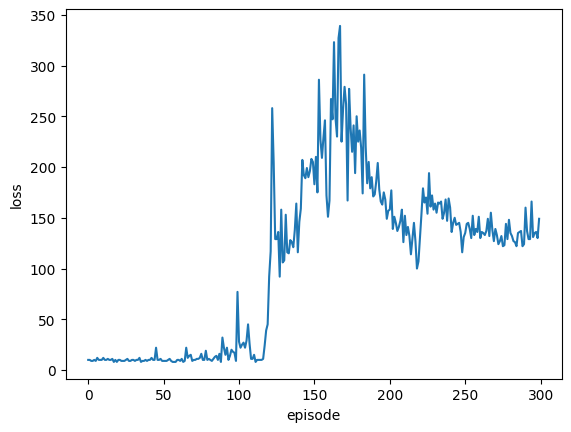

Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [11]:
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(reward_history)), reward_history)
plt.show()

env.play()

In [12]:
# @title Chap 8.2.3 Target Network - 5 (Inference)
agent.epsilon = 0
state = env.reset()[0]
done = False
total_reward = 0

while not done:
    action = agent.get_action(state)
    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    state = next_state
    total_reward += reward

print("total reward : ", total_reward)
env.play()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


total reward :  145.0
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


------

#### Chap 8.4.1 Double DQN

DQN :
- $R_t + \gamma \underset{a}{\operatorname{max}}Q_{θ'}(S_{t+1}, a)$

Double DQN :
- Address the issue of overfitting
- $R_t + \gamma Q_{θ'}\bigg(S_{t+1}, \underset{a}{\operatorname{argmax}} Q_{θ}(S_{t+1}, a)\bigg)$

#### 8.4.2 Prioritized Experience Replay (PER)

- $\delta_{t} = |R_t + \gamma \underset{a}{\operatorname{max}}Q_{θ'}(S_{t+1}, a) - Q_{θ}(S_t, A_t)|$
- Probability of sampling data from reply Buffer(Experience Replay) :
    - $p_i = \frac{\delta_{i}}{\sum_{k=0}^{N}\delta_{k}}$

#### 8.4.3 Dueling DQN

Advantage function
- $A_{\pi}(s,a) = Q_{\pi}(s,a) - V_{\pi}(s)$  
- $Q_{\pi}(s,a) = A_{\pi}(s,a) + V_{\pi}(s)$  

<figure>
<center><img src = "https://www.fromkk.com/images/ddqn_duel_dqn.png"></center>

<figcaption align="center"> DQN vs. Dueling DQN</figcaption>
</figure>
